<a href="https://colab.research.google.com/github/LucasColas/ML01-Machine-Learning-for-everyone/blob/main/ML01_TD6_Exercices_KNN_and_Cross_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML01 : TD6 - Performance d'un modèle et Validation-Croisée

Réalisé par Cyprien Gilet et Khaled Belahcene

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
import scipy.stats as stats

from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

# 1. Implémentation fonctions d'évaluation des performances d'un classifieur

**Question 1.** Dans le fichier *functions.ipynb*, implémenter les différentes fonctions permettant d'évaluer la performance d'un classifieur $\delta\in\Delta$ :
- Risques d'erreur empirique par classe $\hat{R}_k(\delta)$ en fonction d'une fonction de perte $L$ quelconque.
- Risque d'erreur empirique moyen $\hat{r}(\delta)$ en fonction d'une fonction de perte $L$ quelconque.
- Accuracy moyenne $\mathrm{Acc}(\delta)$.
- Accuraces par classe $\mathrm{Acc}_k(\delta)$.
- Matrice de confusion $C(\delta)$.

Le code ci-dessous permet d'importer ces fonctions dans ce Notebook présent.

In [1]:
run functions.ipynb

ERROR:root:File `'functions.ipynb.py'` not found.


### Sur colab on mettre directement les fonctions dans ce notebook

In [41]:
def compute_risk_per_class(YR, Yhat, K, L): 
    '''
    Parameters
    ----------
    YR : DataFrame
        Real labels.
    Yhat : Array
        Predicted labels.
    K : int
        Number of classes.
    L : Array
        Loss Function.

    Returns
    -------
    R : Array of floats
        Conditional risks.
    '''
   
    R = np.zeros(K)
    
    # À compléter...
    confmat = np.zeros((K, K))
    print("confmat shape : ", confmat.shape)
    print("L shape : ", L.shape)
    R = np.zeros(K)
    for k in range(0, K):
        nk = np.sum(YR==k+1)
        if nk > 0:
            Ik = np.where(YR==k+1)
            for l in range(0, K):
                confmat[k,l] = np.sum(Yhat[Ik]==l+1)/nk
        R[k] = L[k, :].dot(confmat[k, :]) 
    
    return R

In [3]:
def compute_average_risk(YR, Yhat, K, L):
    '''
    Parameters
    ----------
    YR : DataFrame
        Real labels.
    Yhat : Array
        Predicted labels.
    K : int
        Number of classes.
    L : Array
        Loss Function.

    Returns
    -------
    r : float
        Global risk.
    '''
    
    
    # À compléter...
    n = YR.shape[0]
    r = 0
    R_classe = compute_risk_per_class(YR, Yhat, K, L)
    for k in range(K):
      Ik = np.where(YR==k+1)
      pk = np.sum(YR==k+1)/n
      
      r += pk*R_classe[k]
    
    return r

In [4]:
def compute_accuracy(YR, Yhat):
    '''
    Parameters
    ----------
    YR : DataFrame
        Real labels.
    Yhat : Array
        Predicted labels.

    Returns
    -------
    Acc : float
        Accuracy.
    '''
    
    
    # À compléter...
    n = YR.shape[0]
    Acc = np.sum(YR==Yhat)/n

    
    return Acc

In [5]:
def compute_accuracy_per_class(YR, Yhat, K):
    '''
    Parameters
    ----------
    YR : DataFrame
        Real labels.
    Yhat : Array
        Predicted labels.
    K : int
        Number of classes.

    Returns
    -------
    Acc_per_class : Array
        Accuracies per class
    '''
    
    Acc_per_class = np.zeros(K)
    
    # À compléter...
    for k in range(K):
      Ik = np.where(YR==k+1)
      nk = np.sum(YR==k+1)
      if nk > 0:

        Acc_per_class[k] = np.sum(Yhat[Ik] == k+1)/nk
    
    return Acc_per_class

In [38]:
def compute_confusion_matrix(YR, Yhat, K):
    '''
    Parameters
    ----------
    YR : DataFrame
        Real labels.
    Yhat : Array
        Predicted labels.
    K : int
        Number of classes.

    Returns
    -------
    confmat : Array
        Confusion Matrix
    '''
    
    # À compléter...
    confmat = np.zeros((K,K))
    for k in range(K):
      nk = np.sum(YR == k+1)
      if nk > 0:
        Ik = np.where(YR==k+1)
        for l in range(K):
          confmat[k,l] = np.sum(Yhat[Ik] == l+1)/nk
    
    return confmat

# 2. Validation croisée KNN sur base de données Diabete_UCI

Dans cette section nous souhaitons apprendre le classifieur KNN à partir d'une validation croisée sur la base de données Diabete UCI. Nous considèrerons la fonction de perte $L_{0\text{-}1}$.

Les cellules suivantes permettent d'importer la base de données.

In [11]:
df = pd.read_csv('diabetes_UCI.csv')
print(df.columns.values)
print('df =', df)
print('df_Info =', df.info())

df = df.reset_index()
df.drop(['index'], axis='columns', inplace=True)

['Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness' 'Insulin' 'BMI'
 'DiabetesPedigreeFunction' 'Age' 'Outcome']
df =      Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        

In [35]:

YRdf = pd.DataFrame(df['Outcome'])
print('np.unique(YRdf) =', np.unique(YRdf))
YR = np.array(YRdf).ravel()+1
print('np.unique(YR) =', np.unique(YR))

Xdf = df.copy()
Xdf.drop(['Outcome'], axis='columns', inplace=True)
#Xdf.info()

K = int(np.max(YR))
X = np.array(Xdf)


np.unique(YRdf) = [0 1]
np.unique(YR) = [1 2]


In [36]:
K

2

**Question 2.1.** Implémenter la fonction de perte $L_{0\text{-}1}$.

In [37]:
# RÉPONSE À LA QUESTION 2.1:
L = np.ones((K,K))
np.fill_diagonal(L,0)
L

array([[0., 1.],
       [1., 0.]])

**Question 2.2.** Créer une procédure de validation croisée permettant selectionner le nombre de voisins optimal de sorte à ce que l'on obtenienne une erreur de généralisation satisfaisante. On pourra s'inspirer de la structure suivante : 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

processing fold f = 0
    KNN -> kn = 1
    KNN -> kn = 10
    KNN -> kn = 20
    KNN -> kn = 30
    KNN -> kn = 40
    KNN -> kn = 50
    KNN -> kn = 100
processing fold f = 1
    KNN -> kn = 1
    KNN -> kn = 10
    KNN -> kn = 20
    KNN -> kn = 30
    KNN -> kn = 40
    KNN -> kn = 50
    KNN -> kn = 100
processing fold f = 2
    KNN -> kn = 1
    KNN -> kn = 10
    KNN -> kn = 20
    KNN -> kn = 30
    KNN -> kn = 40
    KNN -> kn = 50
    KNN -> kn = 100
processing fold f = 3
    KNN -> kn = 1
    KNN -> kn = 10
    KNN -> kn = 20
    KNN -> kn = 30
    KNN -> kn = 40
    KNN -> kn = 50
    KNN -> kn = 100
processing fold f = 4
    KNN -> kn = 1
    KNN -> kn = 10
    KNN -> kn = 20
    KNN -> kn = 30
    KNN -> kn = 40
    KNN -> kn = 50
    KNN -> kn = 100


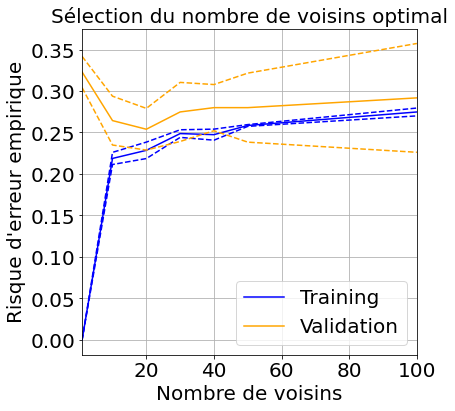

In [23]:
# RÉPONSE À LA QUESTION 2.2:
np.random.seed(407)

nbFolds = 5
kf = KFold(n_splits=nbFolds, shuffle=True)
kfSplit = kf.split(X)

stock_kn = np.array([1, 10, 20, 30, 40, 50, 100])
nb_kn = stock_kn.shape[0]
stock_average_risk_Train = np.zeros((nbFolds,nb_kn))
stock_average_risk_Val = np.zeros((nbFolds,nb_kn))

f = 0
t = 0

for train, val in kfSplit:
    
    print("processing fold f =", f) 
    
    XTrain, XVal, YRTrain, YRVal = X[train,:], X[val,:], YR[train], YR[val]
    
    for kn in stock_kn:
        ### KNN 
        print("    KNN -> kn =", kn)
        model_KNN = KNeighborsClassifier(n_neighbors=kn, metric='euclidean')
        model_KNN.fit(XTrain, YRTrain.ravel())

        # Prediction on the training samples
        YhatTrainKNN = model_KNN.predict(XTrain)
        stock_average_risk_Train[f,t] = compute_average_risk(YRTrain, YhatTrainKNN, K, L)

        # Prediction on the testing samples
        YhatValKNN = model_KNN.predict(XVal)
        stock_average_risk_Val[f,t] = compute_average_risk(YRVal, YhatValKNN, K, L)
        
        t = t+1
    
    f = f+1
    t = 0
    
    
    
# FiGURE RISQUE MOYEN VERSUS NOMBRE DE VOISINS :
fig_select_kn = plt.figure(figsize=(6,6))
ax1 = fig_select_kn.add_subplot(1,1,1)

ax1.plot(stock_kn, np.mean(stock_average_risk_Train,0), color='blue', label='Training')
ax1.plot(stock_kn, np.mean(stock_average_risk_Train,0)-np.std(stock_average_risk_Train,0), color='blue',ls='--')
ax1.plot(stock_kn, np.mean(stock_average_risk_Train,0)+np.std(stock_average_risk_Train,0), color='blue',ls='--')

ax1.plot(stock_kn, np.mean(stock_average_risk_Val,0), color='orange', label='Validation')
ax1.plot(stock_kn, np.mean(stock_average_risk_Val,0)-np.std(stock_average_risk_Val,0), color='orange',ls='--')
ax1.plot(stock_kn, np.mean(stock_average_risk_Val,0)+np.std(stock_average_risk_Val,0), color='orange',ls='--')
ax1.legend(fontsize=20, loc='lower right')
ax1.set_xlabel("Nombre de voisins",fontsize=20)
ax1.set_ylabel("Risque d'erreur empirique",fontsize=20)
ax1.set_title("Sélection du nombre de voisins optimal",fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xlim([np.min(stock_kn),np.max(stock_kn)])
ax1.grid()
#ax1.set_xscale('log')


In [ ]:
np.random.seed(407)

nbFolds = 5
kf = KFold(n_splits=nbFolds, shuffle=True)
kfSplit = kf.split(X)

stock_average_risk_Train = np.zeros(nbFolds)
stock_average_risk_Val = np.zeros(nbFolds)

stock_RiskPerClass_Train = np.zeros((nbFolds,K))
stock_RiskPerClass_Val = np.zeros((nbFolds,K))

stock_Accuracy_Train = np.zeros(nbFolds)
stock_Accuracy_Val = np.zeros(nbFolds)

stock_AccPerClass_Train = np.zeros((nbFolds,K))
stock_AccPerClass_Val = np.zeros((nbFolds,K))

stock_ConfMat_Train = np.zeros((nbFolds,K,K))
stock_ConfMat_Val = np.zeros((nbFolds,K,K))


f = 0
kn = 20 # Nombre optimal de voisins

for train, val in kfSplit:
    
    print("processing fold f =", f) 
    
    XTrain, XVal, YRTrain, YRVal = X[train,:], X[val,:], YR[train], YR[val]
    
    ### KNN 
    model_KNN = KNeighborsClassifier(n_neighbors=kn, metric='euclidean')
    model_KNN.fit(XTrain, YRTrain.ravel())

    # Evaluations on the training set
    YhatTrainKNN = model_KNN.predict(XTrain)
    print(YRTrain.shape)
    print(YhatTrainKNN.shape)
    stock_average_risk_Train[f] = compute_average_risk(YRTrain, YhatTrainKNN, K, L)
    stock_RiskPerClass_Train[f,:] = compute_risk_per_class(YRTrain, YhatTrainKNN, K, L)
    stock_Accuracy_Train[f] = compute_accuracy(YRTrain, YhatTrainKNN)
    stock_AccPerClass_Train[f,:] = compute_accuracy_per_class(YRTrain, YhatTrainKNN, K)
    stock_ConfMat_Train[f,:,:] = compute_confusion_matrix(YRTrain, YhatTrainKNN, K)

    # Evaluations on the Validation set 
    YhatValKNN = model_KNN.predict(XVal)
    stock_average_risk_Val[f] = compute_average_risk(YRVal, YhatValKNN, K, L)
    stock_RiskPerClass_Val[f,:] = compute_risk_per_class(YRVal, YhatValKNN, K, L)
    stock_Accuracy_Val[f] = compute_accuracy(YRVal, YhatValKNN)
    stock_AccPerClass_Val[f,:] = compute_accuracy_per_class(YRVal, YhatValKNN, K)
    stock_ConfMat_Val[f,:,:] = compute_confusion_matrix(YRVal, YhatValKNN, K)
    
    f = f+1

    
    

In [43]:
print('stock_average_risk_Train =', stock_average_risk_Train)
print('stock_average_risk_Val =', stock_average_risk_Val)
print('')
print('')
print('stock_RiskPerClass_Train =', stock_RiskPerClass_Train)
print('stock_RiskPerClass_Val =', stock_RiskPerClass_Val)
print('')
print('')
print('stock_Accuracy_Train =', stock_Accuracy_Train)
print('stock_Accuracy_Val =', stock_Accuracy_Val)
print('')
print('')
print('stock_AccPerClass_Train =', stock_AccPerClass_Train)
print('stock_AccPerClass_Val =', stock_AccPerClass_Val)
print('')
print('')
print('Average stock_ConfMat_Train =', np.mean(stock_ConfMat_Train,0))
print('Average stock_ConfMat_Val =', np.mean(stock_ConfMat_Val,0))

stock_average_risk_Train = [0.21498371 0.24267101 0.21986971 0.23252033 0.23252033]
stock_average_risk_Val = [0.25974026 0.23376623 0.24025974 0.23529412 0.30065359]


stock_RiskPerClass_Train = [[0.07848101 0.46118721]
 [0.07788945 0.5462963 ]
 [0.0879397  0.46296296]
 [0.0964467  0.47511312]
 [0.07228916 0.565     ]]
stock_RiskPerClass_Val = [[0.16190476 0.46938776]
 [0.09803922 0.5       ]
 [0.06862745 0.57692308]
 [0.0754717  0.59574468]
 [0.08235294 0.57352941]]


stock_Accuracy_Train = [0.78501629 0.75732899 0.78013029 0.76747967 0.76747967]
stock_Accuracy_Val = [0.74025974 0.76623377 0.75974026 0.76470588 0.69934641]


stock_AccPerClass_Train = [[0.92151899 0.53881279]
 [0.92211055 0.4537037 ]
 [0.9120603  0.53703704]
 [0.9035533  0.52488688]
 [0.92771084 0.435     ]]
stock_AccPerClass_Val = [[0.83809524 0.53061224]
 [0.90196078 0.5       ]
 [0.93137255 0.42307692]
 [0.9245283  0.40425532]
 [0.91764706 0.42647059]]


Average stock_ConfMat_Train = [[0.9173908  0.0826092 ]
 [0.502